In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

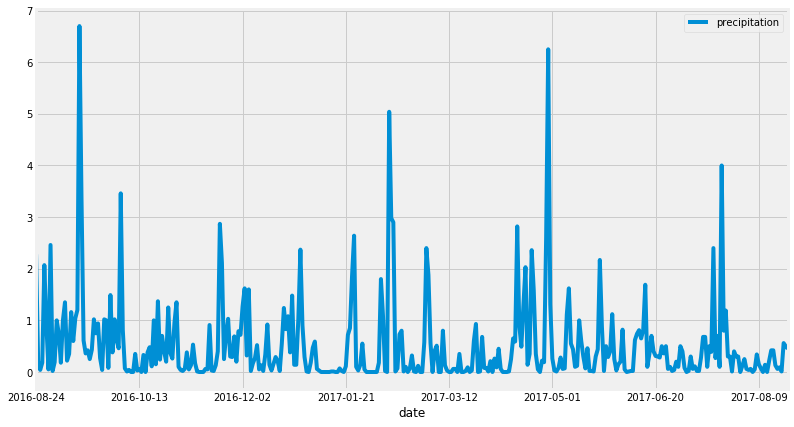

In [10]:
from dateutil.parser import parse
import matplotlib.dates as mdates

vacation_start_date = "2020-09-04"
vacation_end_date = "2020-09-13"

# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
query_date = parse(last_date[0]) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,func.max(Measurement.prcp)]

precipitations = session.query(*sel).filter(Measurement.date >= query_date).group_by(Measurement.date).all()

precipitations
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitations, columns=['date', 'precipitation']).set_index("date")

# Sort the dataframe by date
df = df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12,7))
df.plot(ax=ax)
#df.plot(kind=bar, ax=ax)

# n = 39
# for index, label in enumerate(ax.xaxis.get_ticklabels()):
#    if index % n != 0:
#        label.set_visible(False)

plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
import scipy.stats as sts

prec_amt = df['precipitation']

# Demonstrate calculating measures of central tendency
mean_numpy = np.mean(prec_amt)
print(f"The mean precipitation at Hawaii is {mean_numpy}")

median_numpy = np.median(prec_amt)
print(f"The median precipitation at Hawaii is {median_numpy}")

mode_scipy = sts.mode(prec_amt)
print(f"The mode precipitation at Hawaii is {mode_scipy}")

# Demonstrate calculating the variance and standard deviation using the different modules
var_numpy = np.var(prec_amt,ddof = 0)
print(f"The population variance using the NumPy module is {var_numpy}")

sd_numpy = np.std(prec_amt,ddof = 0)
print(f"The population standard deviation using the NumPy module is {sd_numpy}")

# Calculate the 68-95-99.7 rule using the standard deviation
print(f"Roughly 68% of the data is between {round(mean_numpy-sd_numpy,3)} and {round(mean_numpy+sd_numpy,3)}")
print(f"Roughly 95% of the data is between {round(mean_numpy-2*sd_numpy,3)} and {round(mean_numpy+2*sd_numpy,3)}")
print(f"Roughly 99.7% of the data is between {round(mean_numpy-3*sd_numpy,3)} and {round(mean_numpy+3*sd_numpy,3)}")

# Demonstrate calculating the z-scores using SciPy
# z_scipy = sts.zscore(prec_amt)
# print(f"The z-scores using the SciPy module are {z_scipy}")

The mean precipitation at Hawaii is 0.5172876712328772
The median precipitation at Hawaii is 0.25
The mode precipitation at Hawaii is ModeResult(mode=array([0.]), count=array([48]))
The population variance using the NumPy module is 0.6856827802589612
The population standard deviation using the NumPy module is 0.8280596477663679
Roughly 68% of the data is between -0.311 and 1.345
Roughly 95% of the data is between -1.139 and 2.173
Roughly 99.7% of the data is between -1.967 and 3.001


In [12]:
# Design a query to show how many stations are available in this dataset?

sel = [func.count(Station.station)]

stations = session.query(*sel).all()

stations

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Station.station, func.count(Measurement.date)]
station_counts = session.query(*sel).filter(Station.station == Measurement.station).group_by(Station.station).order_by(func.count(Measurement.date).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = station_counts[0][0]
most_active_station

sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
station_temp_stats = session.query(*sel).filter(Measurement.station == most_active_station).group_by(Measurement.station).all()
station_temp_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

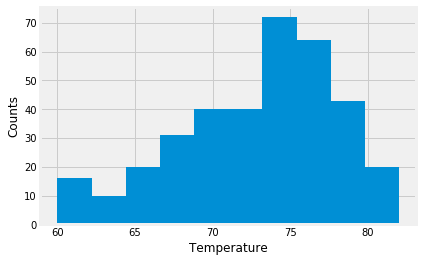

In [15]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).order_by(Measurement.date.desc()).first()

query_date = parse(last_date[0]) - dt.timedelta(days=365)

sel = [Measurement.tobs]
station_temp_stats = session.query(*sel).filter(Measurement.station == most_active_station).filter(Measurement.date >= query_date).all()
station_temp_stats

# sel2 = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
# station_temp_stats2 = session.query(*sel2).filter(Measurement.station == most_active_station).filter(Measurement.date >= query_date).all()
# print(station_temp_stats2)

tempbins = []

for i in range(0,len(station_temp_stats)):
    tempbins.append(station_temp_stats[i][0])

tempbins_df = pd.DataFrame(tempbins, columns=['tobs'])

bins = [59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83]

group_names = [60,62,64,66,68,70,72,74,76,78,80,82]

tempbins_df["TempBin"] = pd.cut(tempbins_df['tobs'], bins, labels=group_names, include_lowest=True)
tempbins_df

plt.hist(tempbins_df["TempBin"])
plt.xlabel('Temperature')
plt.ylabel('Counts')
plt.show()
# print(sts.normaltest(tempbins_df["TempBin"].sample(100)))

#tempbins_df.TempBin.value_counts()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start_date = "2020-09-04"
vacation_end_date = "2020-09-13"

last_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).order_by(Measurement.date.desc()).first()

query_date = parse(last_date[0]) - dt.timedelta(days=365)

query_date_year = int(query_date.date().strftime("%Y"))

vacation_start_date_month = int(dt.datetime.strptime(vacation_start_date, '%Y-%m-%d').date().strftime("%m"))

vacation_start_date_day = int(dt.datetime.strptime(vacation_start_date, '%Y-%m-%d').date().strftime("%d"))

vacation_end_date_month = int(dt.datetime.strptime(vacation_end_date, '%Y-%m-%d').date().strftime("%m")
)
vacation_end_date_day = int(dt.datetime.strptime(vacation_end_date, '%Y-%m-%d').date().strftime("%d"))

query_vsd = dt.date(query_date_year, vacation_start_date_month, vacation_start_date_day)

query_vse = dt.date(query_date_year, vacation_end_date_month, vacation_end_date_day)

result = calc_temps(query_vsd, query_vse)

print(result)






[(71.0, 77.29508196721312, 84.0)]


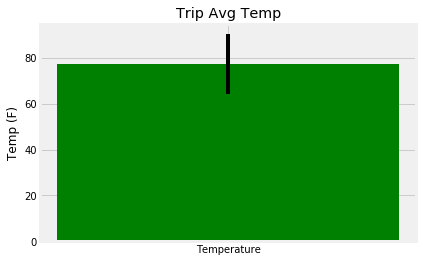

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = "Temperature"
temp = result[0][1]
variance = result[0][2] - result[0][0]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x, temp, color='green', yerr=variance)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

plt.show()


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp) ]
station_prcp_stats = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= query_vsd).filter(Measurement.date <= query_vse).group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_prcp_stats

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.12),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.8900000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.47),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.7100000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.18),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.0100000000000002)]

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
vacation_start_date = "2020-09-04"
vacation_end_date = "2020-09-13"

# Use the start and end date to create a range of dates

# date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]

deltadate = dt.datetime.strptime(vacation_end_date, '%Y-%m-%d') - dt.datetime.strptime(vacation_start_date, '%Y-%m-%d')

diff = deltadate.days + 1

date_list = [dt.datetime.strptime(vacation_start_date, '%Y-%m-%d') + dt.timedelta(days=x) for x in range(diff)]

date_list
# Stip off the year and save a list of %m-%d strings

md_list = [x.strftime("%m-%d") for x in date_list]


# Loop through the list of %m-%d strings and calculate the normals for each date
for x in md_list:
    normals.append(daily_normals(x))

normals

[[(68.0, 76.27083333333333, 84.0)],
 [(66.0, 75.91489361702128, 84.0)],
 [(66.0, 74.91111111111111, 81.0)],
 [(64.0, 75.18, 82.0)],
 [(66.0, 76.22222222222223, 83.0)],
 [(68.0, 76.36538461538461, 84.0)],
 [(67.0, 76.61224489795919, 85.0)],
 [(70.0, 76.69565217391305, 83.0)],
 [(68.0, 75.89795918367346, 85.0)],
 [(68.0, 75.875, 82.0)]]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_dates = [x.strftime("%Y-%m-%d") for x in date_list]

normals[0][0][0]

tmin = []
tmax = []
tavg = []

for x in range(len(normals)):
    tmin.append(int(normals[x][0][0]))
    tmax.append(int(normals[x][0][2]))
    tavg.append(int(normals[x][0][1]))


df = pd.DataFrame({'date': trip_dates, 'tmin': tmin, 'tmax': tmax, 'tavg': tavg})\
        .set_index('date')

df

,tmin,tmax,tavg
date,,,
2020-09-04,68,84,76
2020-09-05,66,84,75
2020-09-06,66,81,74
2020-09-07,64,82,75
2020-09-08,66,83,76
2020-09-09,68,84,76
2020-09-10,67,85,76
2020-09-11,70,83,76
2020-09-12,68,85,75


Text(0.5, 0, 'Date')

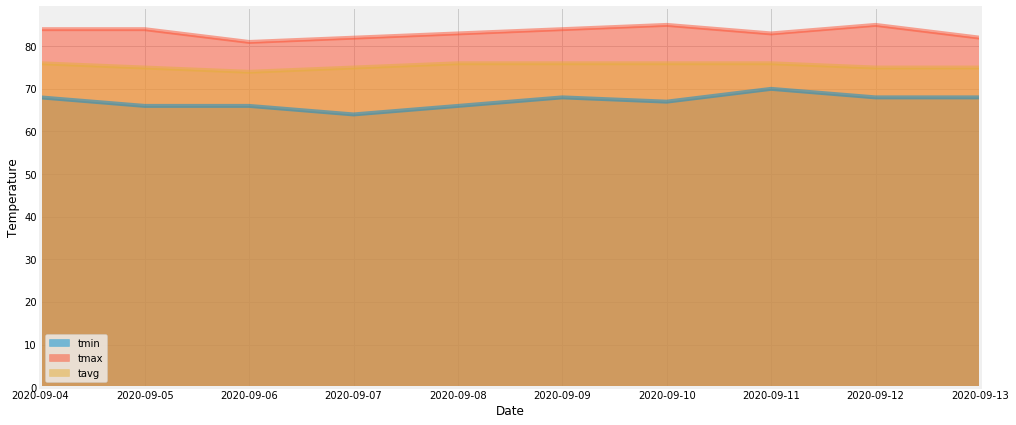

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df.plot(kind='area', stacked=False, figsize=(15,7))
ax.set_ylabel("Temperature")
ax.set_xlabel("Date")
